In [1]:
import torch
import gpytorch
import sys
import os
sys.path.append(os.path.abspath('../..'))
from data import PVWeatherLoader

print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [2]:
# data parameters
DAY_INIT = 20
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 8
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 10
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (53.5, -3)
RADIUS = 0.4
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [3]:
loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    # season='spring',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 7 sec

Number of unique lat lon pairs: 12


Loaded 10 systems


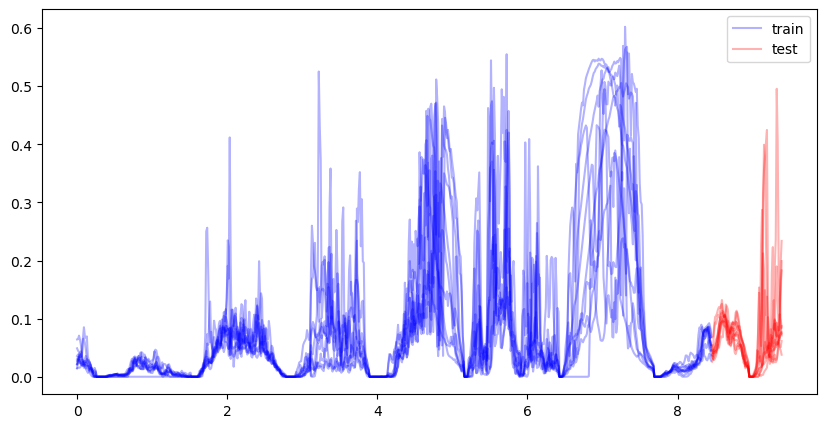

In [4]:
from data.utils import train_test_split
from matplotlib import pyplot as plt
dict_input = {
    'x_train': [],
    'y_train': [],
    'x_test': [],
    'y_test': [],
    'task_indices_train': [],
    'task_indices_test': []
}

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, (X, y) in enumerate(loader):
    t = torch.linspace(0, 10, X.size(0)).unsqueeze(-1) 
    # get t in a format that is the same size as X and each column is the t vector
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour=12, minute_interval=5, day_min=DAY_MIN, day_max=DAY_MAX, n_hours=6)
    
    n_tr = x_train.size(0)
    n_te = x_test.size(0)
    t_train = t[:n_tr]
    t_test = t[n_tr:n_tr+n_te]
    if i == 0:
        ax.plot(t_train, y_train, color='b', alpha=0.3, label='train')
        ax.plot(t_test, y_test, color='r', alpha=0.3, label='test')
        ax.legend()
    else:
        ax.plot(t_train, y_train, color='b', alpha=0.3)
        ax.plot(t_test, y_test, color='r', alpha=0.3)
    x_train = torch.cat([x_train, t_train], dim=-1)
    x_test = torch.cat([x_test, t_test], dim=-1)

    n_tr = x_train.size(0)
    n_te = x_test.size(0)
    index_tr = torch.ones(n_tr, dtype=torch.long) * i
    index_te = torch.ones(n_te, dtype=torch.long) * i
    
    dict_input['x_train'].append(x_train)
    dict_input['y_train'].append(y_train)
    dict_input['x_test'].append(x_test)
    dict_input['y_test'].append(y_test)
    dict_input['task_indices_train'].append(index_tr)
    dict_input['task_indices_test'].append(index_te)

    if i == N_SYSTEMS - 1:
        print(f"Loaded {i + 1} systems")
        plt.rcParams['font.family'] = 'Arial'
        plt.show();
        break
        
      
x_train = torch.cat(dict_input['x_train'])
y_train = torch.cat(dict_input['y_train'], dim=0)
task_indices_train = torch.cat(dict_input['task_indices_train'])

x_test = torch.cat(dict_input['x_test'])
y_test = torch.cat(dict_input['y_test'], dim=0)
task_indices_test = torch.cat(dict_input['task_indices_test'])


y_train = torch.cat(dict_input['y_train'])
y_test = torch.cat(dict_input['y_test'])

# for visualizing
_y_tr = torch.stack(dict_input['y_train'], dim=-1)
_y_te = torch.stack(dict_input['y_test'], dim=-1)


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([6490, 7])
torch.Size([6490])
torch.Size([720, 7])
torch.Size([720])


In [6]:
from kernels import get_mean_covar_weather
from likelihoods import HadamardBetaLikelihood

num_tasks =  len(task_indices_test.unique()) 
num_latents = 6

# TODO change to num_tasks if independent
mean, covar = get_mean_covar_weather(num_latents=num_latents,
                                      d=x_train.shape[-1],
                                      combine='product')
likelihood = HadamardBetaLikelihood(num_tasks=num_tasks, 
                                    scale=30)
interval = 10

In [7]:
from models import HadamardGPModel

model = HadamardGPModel(
    X=x_train[::interval],
    y=y_train[::interval],
    mean_module=mean,
    covar_module=covar,
    likelihood=likelihood,
    num_tasks=num_tasks,
    num_latents=num_latents,
    learn_inducing_locations=True,
    inducing_proportion=0.7,
    variational_type='cholesky',
    jitter=1e-2)


In [8]:
model.set_cpu()
model.fit(n_iter=200, 
          lr=0.1, 
          task_indices=task_indices_train[::interval],
          verbose=True)

Using CPU
Iter 10/200 - Loss: 1.1257303953170776
Iter 20/200 - Loss: 0.08656609058380127
Iter 30/200 - Loss: -0.5652401447296143
Iter 40/200 - Loss: -1.1150131225585938
Iter 50/200 - Loss: -1.4336894750595093
Iter 60/200 - Loss: -1.6379799842834473
Iter 70/200 - Loss: -1.7859160900115967
Iter 80/200 - Loss: -1.896155834197998
Iter 90/200 - Loss: -1.980039119720459
Iter 100/200 - Loss: -2.047940731048584
Iter 110/200 - Loss: -2.10357666015625
Iter 120/200 - Loss: -2.15061354637146
Iter 130/200 - Loss: -2.1887319087982178
Iter 140/200 - Loss: -2.220430850982666
Iter 150/200 - Loss: -2.2560434341430664
Iter 160/200 - Loss: -2.284769296646118
Iter 170/200 - Loss: -2.3089327812194824
Iter 180/200 - Loss: -2.322774887084961
Iter 190/200 - Loss: -2.3329544067382812
Iter 200/200 - Loss: -2.353003978729248


In [9]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist_tr = model.likelihood(model(x_train, task_indices=task_indices_train), task_indices=task_indices_train)
    pred_dist_te = model.likelihood(model(x_test, task_indices=task_indices_test), task_indices=task_indices_test)

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

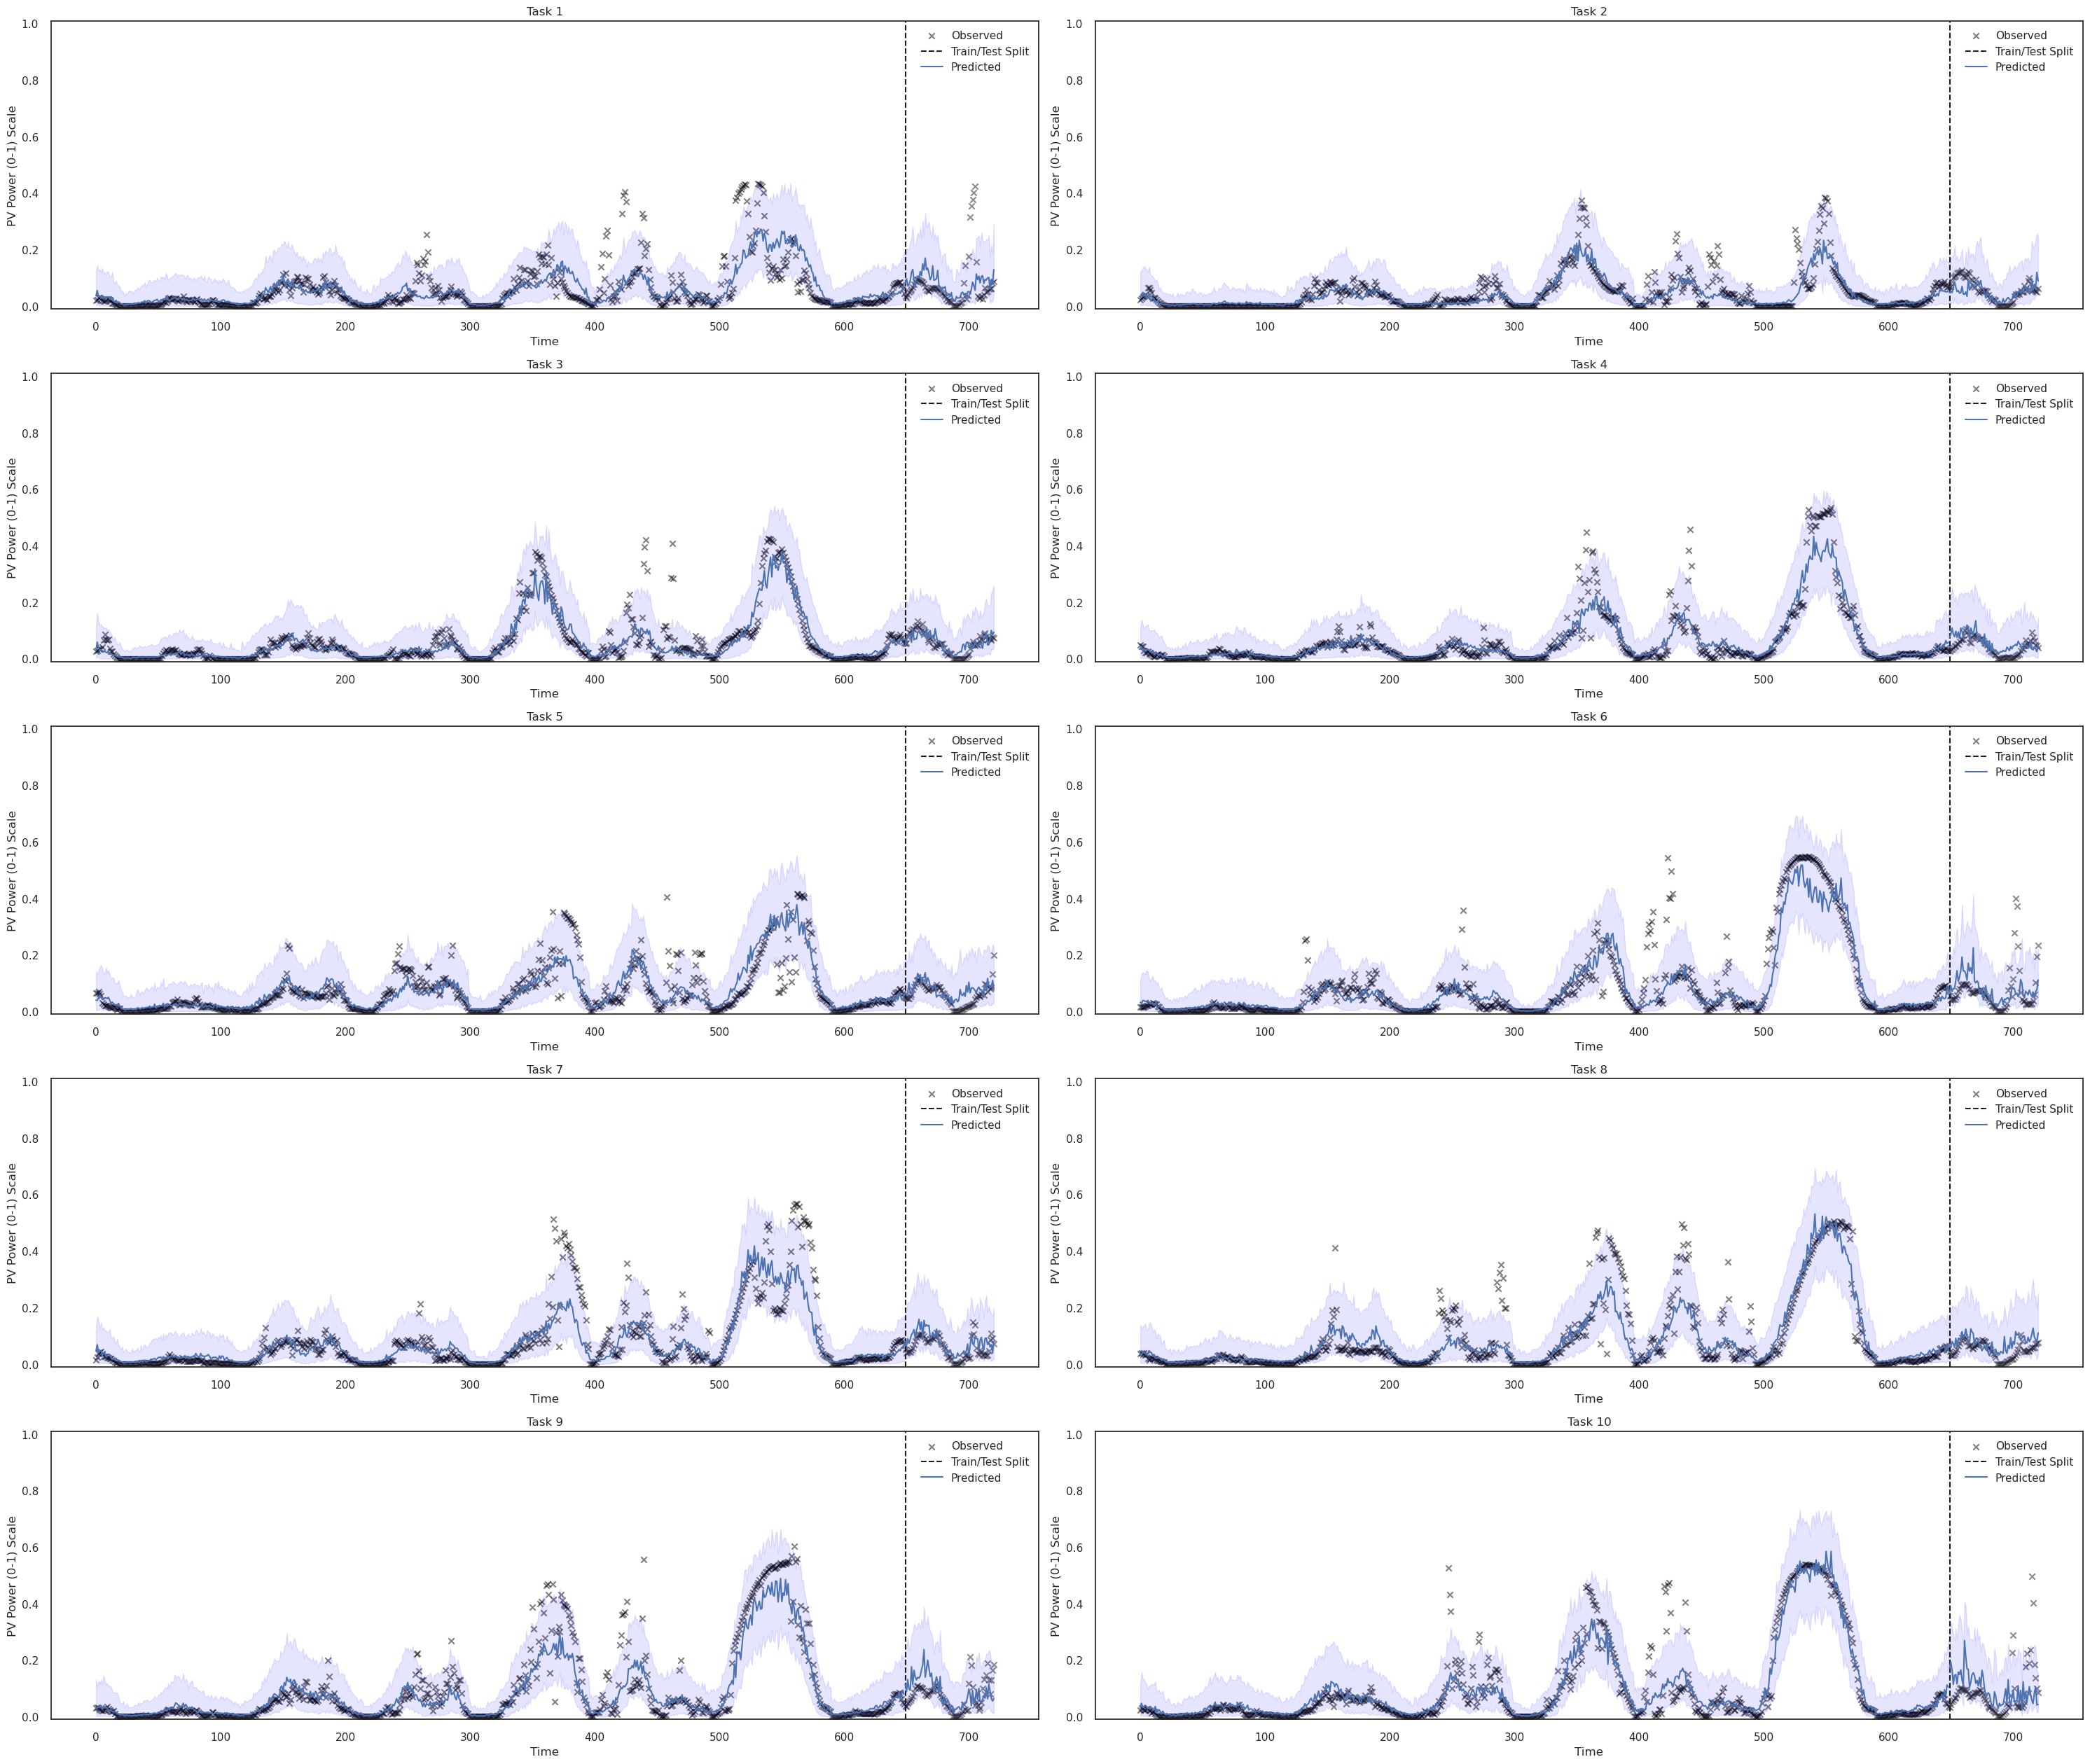

In [10]:
from matplotlib import pyplot as plt
import numpy as np

model.eval()
likelihood.eval()

samples_tr = pred_dist_tr.sample(torch.Size([100]))
samples_te = pred_dist_te.sample(torch.Size([100]))

fig, axs = plt.subplots(num_tasks, 2, figsize=(30, 5 * (num_tasks )))
axs = axs.flatten()

for idx in torch.unique(task_indices_train):

    y_tr, y_te = _y_tr[:, idx], _y_te[:, idx]
    t = np.arange(0, len(y_tr) + len(y_te))
    t_tr, t_te = t[:len(y_tr)], t[len(y_tr):]

    axs[idx].scatter(t_tr, y_tr, label='Observed', color='black', marker='x', alpha=0.5)
    axs[idx].scatter(t_te, y_te,  color='k', marker='x', alpha=0.5)
    axs[idx].axvline(x=len(y_tr), color='k', linestyle='--', label='Train/Test Split')

    samples_tr_idx = samples_tr[:, :, task_indices_train == idx]
    samples_te_idx = samples_te[:, :, task_indices_test == idx]

    y_pred = samples_tr_idx.mean(dim=0).median(dim=0).values
    y_pred_te = samples_te_idx.mean(dim=0).median(dim=0).values
    
    lower_tr = np.quantile(samples_tr_idx.numpy(), 0.025, axis=0).mean(axis=0)
    upper_tr = np.quantile(samples_tr_idx.numpy(), 0.975, axis=0).mean(axis=0)

    lower_te = np.quantile(samples_te_idx.numpy(), 0.025, axis=0).mean(axis=0)
    upper_te = np.quantile(samples_te_idx.numpy(), 0.975, axis=0).mean(axis=0)
    
    
    axs[idx].plot(t_tr, y_pred, color='b', label='Predicted')
    axs[idx].fill_between(t_tr, lower_tr, upper_tr, alpha=0.1, color='blue')
    axs[idx].plot(t_te, y_pred_te, color='b')
    axs[idx].fill_between(t_te, lower_te, upper_te, alpha=0.1, color='blue')


    axs[idx].set_ylim(-0.01, 1.01)
    axs[idx].set_title(f'Task {idx + 1}')
    axs[idx].set_xlabel('Time')
    axs[idx].set_ylabel('PV Power (0-1) Scale')
    axs[idx].legend()

# remove unused axes
for ax in axs[num_tasks:]:
    ax.remove()

plt.tight_layout()
plt.show();

In [101]:
model.likelihood.scale

tensor([[28.0537, 28.5727, 27.9429, 28.8356, 28.5028, 27.9928, 28.1002, 27.9375,
         27.8778, 28.1267]], grad_fn=<SoftplusBackward0>)

In [38]:
covar = model.covar_module

In [11]:
from data.utils import store_gp_module_parameters
store_gp_module_parameters(covar)

{'kernels.0.outputscale': array([0.1765, 0.1123, 0.1373, 0.1653, 0.0652, 0.147 ], dtype=float32),
 'kernels.0.base_kernel.lengthscale': array([0.999 , 1.5928, 1.0152, 0.5114, 1.5515, 1.6401], dtype=float32),
 'kernels.1.outputscale': array([0.1765, 0.1123, 0.1373, 0.1653, 0.0652, 0.147 ], dtype=float32),
 'kernels.1.base_kernel.kernels.0.kernels.0.outputscale': array([1.6631, 0.8155, 1.2594, 2.2645, 0.4408, 1.6022], dtype=float32),
 'kernels.1.base_kernel.kernels.0.kernels.0.base_kernel.lengthscale': array([2.6636, 2.2707, 1.9093, 2.4754, 0.6044, 2.349 ], dtype=float32),
 'kernels.1.base_kernel.kernels.0.kernels.0.base_kernel.period_length': array([0.6052, 0.6096, 0.6111, 0.8202, 0.7541, 0.6207], dtype=float32),
 'kernels.1.base_kernel.kernels.0.kernels.1.outputscale': array([1.6631, 0.8155, 1.2594, 2.2645, 0.4408, 1.6022], dtype=float32),
 'kernels.1.base_kernel.kernels.0.kernels.1.base_kernel.lengthscale': array([866.9151, 837.5056, 875.9815, 910.5081, 660.2974, 891.7659],
       dty

In [126]:
for kernel in model.covar_module.sub_kernels():
    for sub_kernel in kernel.sub_kernels():
        if isinstance(sub_kernel, gpytorch.kernels.AdditiveKernel):
            for sub_sub_kernel in sub_kernel.sub_kernels():
                if isinstance(sub_sub_kernel, gpytorch.kernels.MaternKernel):
                    print(store_gp_module_parameters(sub_sub_kernel))
                    


{'lengthscale': array([988.2264, 998.6365, 765.9655, 996.6907, 976.4872, 985.7377],
      dtype=float32)}
{'lengthscale': array([0.3463, 8.6074, 1.2775, 6.7984, 4.6099, 5.3936], dtype=float32)}
